# Ejemplo de K-means en Spark
Adaptado de https://www.bmc.com/blogs/python-spark-k-means-example/

## Preparación de datos

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat -P data/UCI_heart/

Documentación (pequeña) de la fuente: https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.doc

In [1]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType

In [2]:
cols = ('age',
        'sex',
        'chest_pain',
        'rest_blood_pressure',
        'serum_cholestoral',
        'fast_blood_sugar',
        'rest_ecg_results',
        'max_heart_rate',
        'exercise_induced_angina',
        'exercise_ST_depression',
        'slope_peak_exercise_ST_segment',
        'nb_major_vessels',
        'thal',
        'last')
# ecg:electrocardiographic

In [3]:
schema = StructType([StructField(name, FloatType(), True) for name in cols])

In [4]:
df = spark.read.\
    option("header","false").\
    option("sep"," ").\
    csv("data/UCI_heart/heart.dat", schema=schema) # , sep=" "

In [5]:
df.printSchema()

root
 |-- age: float (nullable = true)
 |-- sex: float (nullable = true)
 |-- chest_pain: float (nullable = true)
 |-- rest_blood_pressure: float (nullable = true)
 |-- serum_cholestoral: float (nullable = true)
 |-- fast_blood_sugar: float (nullable = true)
 |-- rest_ecg_results: float (nullable = true)
 |-- max_heart_rate: float (nullable = true)
 |-- exercise_induced_angina: float (nullable = true)
 |-- exercise_ST_depression: float (nullable = true)
 |-- slope_peak_exercise_ST_segment: float (nullable = true)
 |-- nb_major_vessels: float (nullable = true)
 |-- thal: float (nullable = true)
 |-- last: float (nullable = true)



In [6]:
df.show()

+----+---+----------+-------------------+-----------------+----------------+----------------+--------------+-----------------------+----------------------+------------------------------+----------------+----+----+
| age|sex|chest_pain|rest_blood_pressure|serum_cholestoral|fast_blood_sugar|rest_ecg_results|max_heart_rate|exercise_induced_angina|exercise_ST_depression|slope_peak_exercise_ST_segment|nb_major_vessels|thal|last|
+----+---+----------+-------------------+-----------------+----------------+----------------+--------------+-----------------------+----------------------+------------------------------+----------------+----+----+
|70.0|1.0|       4.0|              130.0|            322.0|             0.0|             2.0|         109.0|                    0.0|                   2.4|                           2.0|             3.0| 3.0| 2.0|
|67.0|0.0|       3.0|              115.0|            564.0|             0.0|             2.0|         160.0|                    0.0|            

In [7]:
features = ('age',
            'sex',
            'chest_pain',
            'rest_blood_pressure',
            'serum_cholestoral',
            'fast_blood_sugar',
            'rest_ecg_results',
            'max_heart_rate',
            'exercise_induced_angina',
            'exercise_ST_depression',
            'slope_peak_exercise_ST_segment',
            'nb_major_vessels')

In [8]:
from pyspark.ml.feature import VectorAssembler

In [9]:
assembler = VectorAssembler(inputCols=features,outputCol="features")

In [10]:
dataset=assembler.transform(df)

In [11]:
dataset.select("features").show(truncate=False)

+------------------------------------------------------------------------+
|features                                                                |
+------------------------------------------------------------------------+
|[70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4000000953674316,2.0,3.0] |
|[67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.600000023841858,2.0,0.0]  |
|[57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.30000001192092896,1.0,0.0]|
|[64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.20000000298023224,2.0,1.0]|
|[74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.20000000298023224,1.0,1.0]|
|[65.0,1.0,4.0,120.0,177.0,0.0,0.0,140.0,0.0,0.4000000059604645,1.0,0.0] |
|[56.0,1.0,3.0,130.0,256.0,1.0,2.0,142.0,1.0,0.6000000238418579,2.0,1.0] |
|[59.0,1.0,4.0,110.0,239.0,0.0,2.0,142.0,1.0,1.2000000476837158,2.0,1.0] |
|[60.0,1.0,4.0,140.0,293.0,0.0,2.0,170.0,0.0,1.2000000476837158,2.0,2.0] |
|[63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0]                |
|[59.0,1.0,4.0,135.0,234.

## KMeans con k=2

In [12]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [13]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dataset.select("features"))

In [14]:
predictions = model.transform(dataset)

In [15]:
predictions.show()

+----+---+----------+-------------------+-----------------+----------------+----------------+--------------+-----------------------+----------------------+------------------------------+----------------+----+----+--------------------+----------+
| age|sex|chest_pain|rest_blood_pressure|serum_cholestoral|fast_blood_sugar|rest_ecg_results|max_heart_rate|exercise_induced_angina|exercise_ST_depression|slope_peak_exercise_ST_segment|nb_major_vessels|thal|last|            features|prediction|
+----+---+----------+-------------------+-----------------+----------------+----------------+--------------+-----------------------+----------------------+------------------------------+----------------+----+----+--------------------+----------+
|70.0|1.0|       4.0|              130.0|            322.0|             0.0|             2.0|         109.0|                    0.0|                   2.4|                           2.0|             3.0| 3.0| 2.0|[70.0,1.0,4.0,130...|         1|
|67.0|0.0|      

In [16]:
evaluator = ClusteringEvaluator()

In [17]:
silhouette = evaluator.evaluate(predictions.select("features","prediction"))
print("Silhouette con la distancia euclidiana = " + str(silhouette))

Silhouette con la distancia euclidiana = 0.570206512687668


In [18]:
cost = model.computeCost(dataset) # deprecated (not in Spark 3.0, use model.summary.trainingCost instead)
print("Within Set Sum of Squared Errors = " + str(cost)) # suma de distancia^2 entre puntos de cada cluster y su centro

Within Set Sum of Squared Errors = 548301.9823859194


In [19]:
model.summary.trainingCost

548301.9823859194

In [20]:
model.summary.clusterSizes

[168, 102]

In [21]:
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[5.29821429e+01 7.44047619e-01 3.12500000e+00 1.28636905e+02
 2.19047619e+02 1.48809524e-01 9.22619048e-01 1.52380952e+02
 2.85714286e-01 1.02142857e+00 1.57738095e+00 5.77380952e-01]
[5.68235294e+01 5.68627451e-01 3.25490196e+00 1.35803922e+02
 3.00078431e+02 1.47058824e-01 1.18627451e+00 1.45225490e+02
 4.01960784e-01 1.09705882e+00 1.59803922e+00 8.23529412e-01]


## Probando varios valores de k

### Con la metrica de Silhouette

In [22]:
silhouettes = []

In [23]:
for k in range(2, 6):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset.select("features"))
    predictions = model.transform(dataset)
    silhouettes.append(evaluator.evaluate(predictions))

In [24]:
silhouettes

[0.570206512687668,
 0.41944597424332125,
 0.4317036542843157,
 0.3833739721073585]

In [25]:
import matplotlib.pyplot as plt

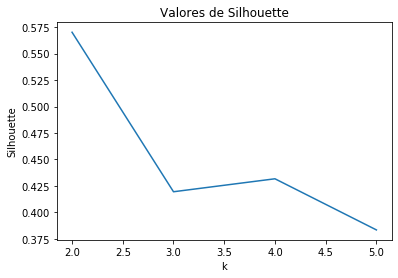

In [37]:
plt.plot(range(2, 6), silhouettes)
plt.title('Valores de Silhouette')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.show()

k=2 tiene el valor de silhouette mas alto, es un buen candidato.

### "Elbow method" con la metrica wcss (within-cluster sum of squares)
Para visualizar el cambio de curba en k=2 necesitamos el valor para k=1 pero KMeans().setK(k) no accepta k=1.
Lo calculamos a mano.

In [27]:
costs = []

In [28]:
aggExpr = []
for column in features:
    aggExpr.append(F.mean(df[column]).alias(column))
averages = df.agg(*aggExpr).collect()[0]

In [29]:
selectExpr = []
for column in features:
    selectExpr.append((dataset[column] - averages[column]).alias(column))
#selectExpr

In [30]:
centroid_df = df.select(selectExpr)

In [31]:
centroid_df = assembler.transform(centroid_df).select("features")

In [32]:
costs.append(centroid_df.rdd.map(lambda x: x.features.norm(2)**2).sum())
costs

[972482.2727687869]

Ahora los otros valores de k

In [33]:
for k in range(2, 6):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset.select("features"))
    costs.append(model.summary.trainingCost)

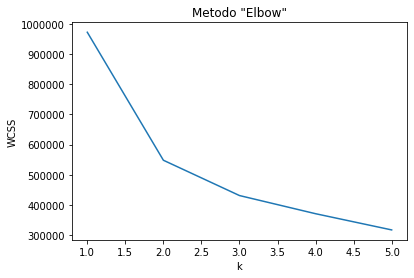

In [36]:
plt.plot(range(1, 6), costs)
plt.title('Metodo "Elbow"')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

Aqui tambien la inflexión mas fuerte està en k=2.